In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.listdir('/content/gdrive/My Drive/Colab Notebooks/Data_sets/Quora')

['train.csv', 'processed.csv']

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings("ignore")
import nltk
import spacy
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.classification import accuracy_score, log_loss,confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier



In [4]:
!pip install --upgrade fuzzywuzzy


Requirement already up-to-date: fuzzywuzzy in /usr/local/lib/python3.6/dist-packages (0.17.0)


In [5]:
!pip install --upgrade distance

Requirement already up-to-date: distance in /usr/local/lib/python3.6/dist-packages (0.1.3)


In [0]:
from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import distance

In [0]:
nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Data_sets/Quora/train.csv")

print(df.shape)

(404290, 6)


In [0]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [0]:
df.groupby("is_duplicate")['id'].count()

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

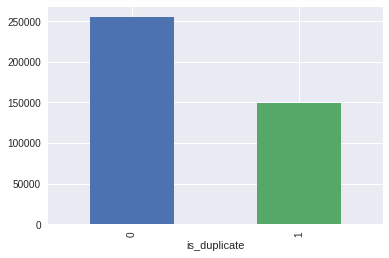

In [0]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [0]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))

In [0]:
unique_qs

537933

In [0]:
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 



Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



In [0]:
(qids.value_counts())[:2]



2559     157
30782    120
dtype: int64

In [0]:

q_vals=qids.value_counts()

In [0]:

q_vals=q_vals.values

In [0]:
q_vals

array([157, 120, 111, ...,   1,   1,   1])

In [0]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


freq_qid1 = Frequency of qid1's

freq_qid2 = Frequency of qid2's

q1len = Length of q1

q2len = Length of q2

q1_n_words = Number of words in Question 1

q2_n_words = Number of words in Question 2

word_Common = (Number of common unique words in Question 1 and Question 2)

word_Total =(Total num of words in Question 1 + Total num of words in Question 2)

word_share = (word_common)/(word_Total)

freq_q1+freq_q2 = sum total of frequency of qid1 and qid2

freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2





In [0]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [0]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


In [0]:

df['word_share'][:2]

0    0.434783
1    0.200000
Name: word_share, dtype: float64

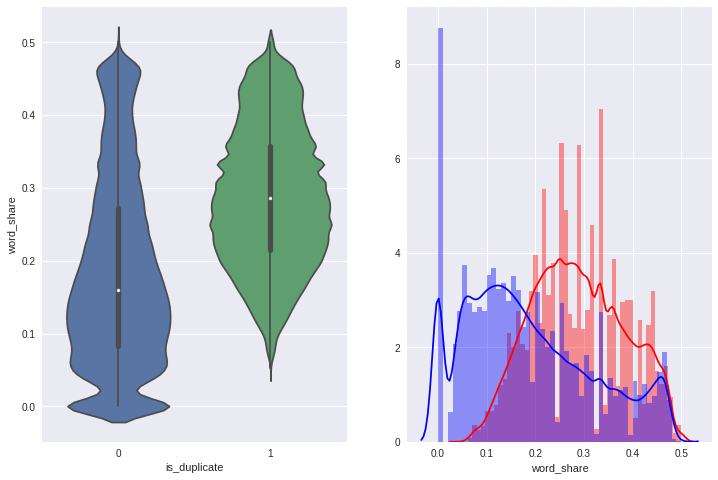

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

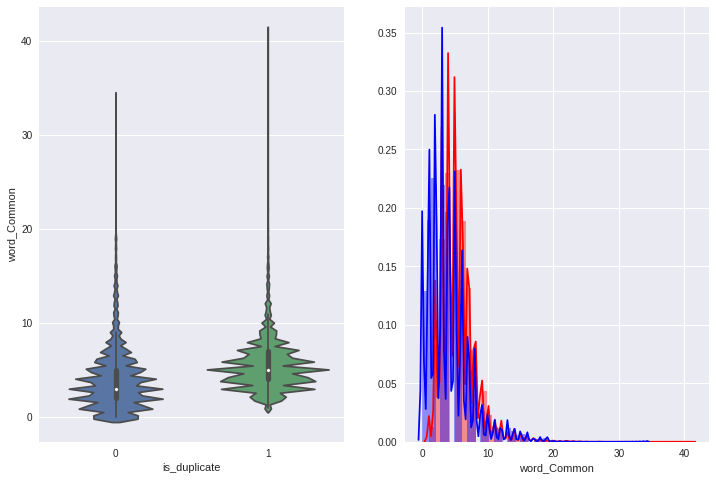

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

In [0]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')# removiing alpha numeric
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()## removing html tag
               
    
    return x
    

cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2 

cwc_min = common_word_count / (min(len(q1_words), len(q2_words))

cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2 

cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 

csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))

csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2

csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2

ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))

ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2

ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))

last_word_eq : Check if last word of both questions is equal or not

last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])

first_word_eq : Check if First word of both questions is equal or not

first_word_eq = int(q1_tokens[0] == q2_tokens[0])

abs_len_diff : Abs. length difference

abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))

mean_len : Average Token Length of both Questions

mean_len = (len(q1_tokens) + len(q2_tokens))/2

fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    #df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [0]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

In [0]:
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

In [0]:
print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [0]:
textp_w=""
for word in p[:1000]:
  textp_w+=" "
  textp_w+=word
  

In [0]:
textp_w="gfg hfelh hkjdh "

In [0]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
df = extract_features(df)
df.head(2)

token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75


In [0]:
df.to_csv('/content/gdrive/My Drive/Colab Notebooks/Data_sets/Quora/processed.csv',index=False)

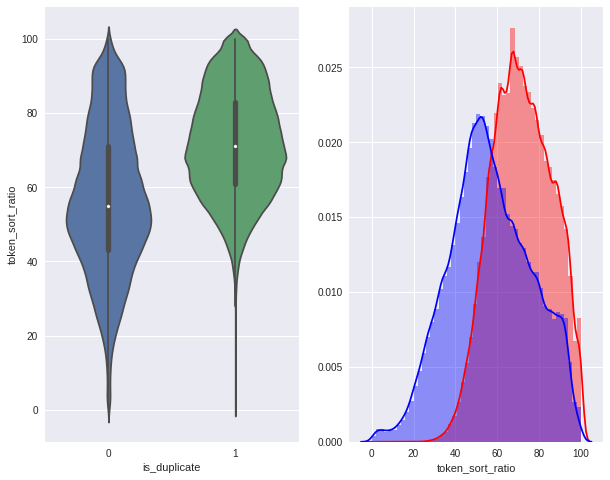

In [0]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [0]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [0]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.015s...
[t-SNE] Computed neighbors for 5000 samples in 0.390s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.120250
[t-SNE] Computed conditional probabilities in 0.307s
[t-SNE] Iteration 50: error = 80.9792557, gradient norm = 0.0431387 (50 iterations in 2.972s)
[t-SNE] Iteration 100: error = 70.3259583, gradient norm = 0.0089968 (50 iterations in 2.044s)
[t-SNE] Iteration 150: error = 68.4484100, gradient norm = 0.0057362 (50 iterations in 2.035s)
[t-SNE] Iteration 200: error = 67.4709473, gradient norm = 0.0045804 (50 iterations in 2.134s)
[t-SNE] Iteration 250: error = 66.9544983, gradient norm = 0.0033147

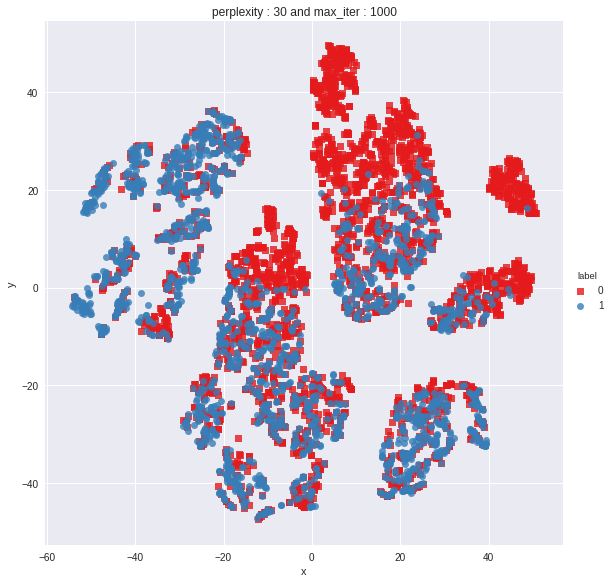

In [0]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [0]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Data_sets/Quora/train.csv")
 
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

<808580x109679 sparse matrix of type '<class 'numpy.float64'>'
	with 8146555 stored elements in Compressed Sparse Row format>

In [9]:
tfidf.get_feature_names()[:3]

['00', '000', '0000']

In [10]:
tfidf.idf_[:3]

array([10.04915925,  7.30459104, 13.90988896])

In [11]:
dict(zip(tfidf.get_feature_names()[:3], tfidf.idf_[:3]))

{'00': 10.04915924690928, '000': 7.304591037001674, '0000': 13.909888957949875}

In [0]:
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
nlp = spacy.load('en_core_web_sm')

In [14]:
nlp

In [15]:
nlp('what is').vector.shape


(384,)

In [0]:
df_slice=df[:10000]

In [20]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df_slice['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df_slice['q1_feats_m'] = list(vecs1)


100%|██████████| 10000/10000 [03:11<00:00, 52.28it/s]


In [21]:
vecs2 = []
for qu2 in tqdm(list(df_slice['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 384])
    for word2 in doc2:
        vec2 = word2.vector
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df_slice['q2_feats_m'] = list(vecs2)

100%|██████████| 10000/10000 [03:09<00:00, 52.39it/s]


In [0]:
df_slice.to_csv('/content/gdrive/My Drive/Colab Notebooks/Data_sets/Quora/featured_1.csv',index=False)

In [0]:
df3_q1 = pd.DataFrame(df_slice.q1_feats_m.values.tolist(), index= df_slice.index)
df3_q2 = pd.DataFrame(df_slice.q2_feats_m.values.tolist(), index= df_slice.index)

In [33]:
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,125.983275,95.636497,42.114723,95.449991,-37.386311,39.400078,-148.116060,-87.851482,110.371956,62.272829,...,16.165591,33.030670,7.019996,-14.793957,15.437511,8.199656,-25.070836,1.571618,1.603733,0.305649
1,-106.871914,80.290392,79.066298,59.302086,-42.175382,117.616717,-144.364301,-127.131524,22.962531,25.397591,...,-4.901130,-4.565389,41.520751,-0.727564,-16.413772,-7.373778,2.638877,-7.403463,2.703062,0.408053
2,7.072883,15.513373,1.846891,85.937587,-33.808812,94.702313,-122.256853,-114.009543,53.922298,60.131800,...,8.359967,-2.165978,10.936576,-16.531656,14.681229,15.633758,-1.210901,14.183829,11.703136,10.148075
3,39.421526,44.137002,-24.010913,85.265858,-0.339031,-9.323151,-60.499656,-37.044772,49.407858,-23.350158,...,3.311411,3.788878,13.398604,-6.592592,6.437366,5.993292,2.732391,-3.727642,5.614119,6.023690
4,31.950128,62.854131,1.778152,36.218740,-45.130867,66.674888,-106.342336,-22.901027,59.835923,62.663943,...,-2.403872,11.991209,8.088483,-15.090196,8.375165,1.727224,-6.601128,11.317404,11.544595,2.478679


In [0]:
#df_pro=df.to_csv('/content/gdrive/My Drive/Colab Notebooks/Data_sets/Quora/processed.csv',index=False)

In [32]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
df1=df[:10000]
frames = [df1, df3_q1, df3_q2]

result = pd.concat(frames,axis=1)

In [36]:
result.head()

,id,qid1,qid2,question1,question2,is_duplicate,0,1,2,3,...,374,375,376,377,378,379,380,381,382,383
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,121.929907,100.083900,72.497898,115.641796,...,16.165591,33.030670,7.019996,-14.793957,15.437511,8.199656,-25.070836,1.571618,1.603733,0.305649
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,-78.070950,54.843756,82.738473,98.191852,...,-4.901130,-4.565389,41.520751,-0.727564,-16.413772,-7.373778,2.638877,-7.403463,2.703062,0.408053
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,-5.355039,73.671827,14.376383,104.130224,...,8.359967,-2.165978,10.936576,-16.531656,14.681229,15.633758,-1.210901,14.183829,11.703136,10.148075
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,5.778361,-34.712039,48.999618,59.699203,...,3.311411,3.788878,13.398604,-6.592592,6.437366,5.993292,2.732391,-3.727642,5.614119,6.023690
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,51.138227,38.587261,123.639507,53.333048,...,-2.403872,11.991209,8.088483,-15.090196,8.375165,1.727224,-6.601128,11.317404,11.544595,2.478679


In [0]:
drop_list=['id','qid1','qid2','question1','question2']
result.drop(drop_list,axis=1,inplace=True)

In [38]:
result.head(2)

,is_duplicate,0,1,2,3,4,5,6,7,8,...,374,375,376,377,378,379,380,381,382,383
0,0,121.929907,100.083900,72.497898,115.641796,-48.370880,34.619056,-172.057793,-92.502629,113.223281,...,16.165591,33.030670,7.019996,-14.793957,15.437511,8.199656,-25.070836,1.571618,1.603733,0.305649
1,0,-78.070950,54.843756,82.738473,98.191852,-51.234823,55.013525,-39.140743,-82.692367,45.161507,...,-4.901130,-4.565389,41.520751,-0.727564,-16.413772,-7.373778,2.638877,-7.403463,2.703062,0.408053


In [0]:
cols = list(result.columns)
for i in cols:
    result[i] = result[i].apply(pd.to_numeric)
   

In [0]:
y_true = result['is_duplicate']

In [0]:
data=result.drop('is_duplicate',axis=1)

In [0]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [46]:
alpha = [10 ** x for x in range(-5, 2)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 0.6594858906574842
For values of alpha =  0.0001 The log loss is: 0.628800961849265
For values of alpha =  0.001 The log loss is: 0.6217442938262232
For values of alpha =  0.01 The log loss is: 0.6314324619077265
For values of alpha =  0.1 The log loss is: 0.6237572697448478
For values of alpha =  1 The log loss is: 0.6242582096874515
For values of alpha =  10 The log loss is: 0.623249609834827


In [0]:
predict_y_1 = sig_clf.predict(X_test)

In [53]:
confusion_matrix(y_test,predict_y_1)


array([[1839,   48],
       [1025,   88]])